#### Synthetic zeeman and polarization data Reconstruction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import data_gen as dg
import recon_funcs as rf
import Sampler as sampler 

### Wavy Field Test

Using geometry, can derive the magnitude of the magnetic field wrt the LOS strength and cos2g

\begin{align}
    \cos^2\gamma &= \frac{bx^2+by^2}{bx^2+by^2+bz^2} = \frac{B_{pos}^2}{B^2}\\
    \sin^2\gamma &= 1 - \cos^2\gamma\\
    \cos\gamma &= \frac{B_{pos}}{B} \\
    \sin\gamma &= \frac{B_{los}}{B} \\
    \sin^2\gamma &= 1 - \cos^2\gamma = \frac{B_{los}^2}{B^2}\\
    B^2 &= \frac{B_{los}^2}{1 - \cos^2\gamma} \\
    B &= \frac{B_{los}}{\sqrt{1 - \cos^2\gamma}}\\
\end{align}

#### PCYCLE

In [ ]:
def p_vcycle(u1_list, b3_list, J, C): # u1_list restricted 2d DATA (U, Q, cos2g), b3_list is the prolonged layers, J is the level we're on

    if len(u1_list) != 0: 
        # this needs to change below
        if J == 1: # this is for the first cell only, where u11 = u21, and skips sampling
            
            u11 = u1_list.pop() # restricted layers, act as data
            
            ############
            # HERE CHECK THAT INPUT u11 indexing IS CORRECT
            b11 = rf.zeeman_recon(u11, plotting=0)
            # b11 = rf.init_recon_2D(u11) # Reconstruct restricted 1x1 square into cube

            b31 = rf.prolong_3D(b11) # prolong into 2x2x2 cube
        
            b3_list.append(b31) # save 2x2x2 cube
            
            J = b31[0][0].shape[0]

            print('[checkpoint]: 1x1 square reconstructed and prolonged.')
            p_vcycle(u1_list, b3_list, J, C)

        else:            
            u12 = u1_list.pop() # restricted 2d DATA; every time a level is used, remove
            
            b12 = rf.init_recon_3D(u12) # reconstruct nxn square into nxnxn cube
            
            b32 = b3_list[-1] # grab previously prolonged cube
            
            print('[checkpoint]: B12 shape = ', np.shape(b12), 'B32 shape = ', np.shape(b32))

            if np.shape(b12) == np.shape(b32):
                # set parameters for sampling
                dtheta   = 0.02
                dphi     = 0.3
                R        = 8000
                rbins    = R//100
                nbins    = 20
                ntrials  = 200
                burn     = 50
                plotting = 1

                # Check Level:
                if u12[0][0].shape[0] < C:  # still growing, still prolongating

                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    print('[checkpoint]: Sampled B shape = ', np.shape(b22))

                    b33 = rf.prolong_3D(b22)

                    print('[checkpoint]: ','B22 shape = ', np.shape(b22), 'B33 shape = ', np.shape(b33))

                    J = b33[0][0].shape[0]

                    b3_list.append(b33)

                    p_vcycle(u1_list, b3_list, J, C)

                elif u12[0][0].shape[0] == C: # Hit last level. No more prolongation, but still want to sample 
                    print(u12[0][0].shape[0])
                    # Sample last level
                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    
                    b3_list.append(b22)

                    print('Ceiling Hit at J = ', u12[0][0].shape[0])
                    return
                else:
                    print('You have gone past input dimensions, something is wrong.')
            else:
                print('Reconstructed and Prolonged B field shapes do not match.')

    else:
        print('All levels reached, returning...') # once on last level, return


#### RCYCLE

In [ ]:
def r_vcycle(tdmap, u1_list, b3_list, C):
    J = tdmap[0][0].shape[0]
    if J == 1: # check size is 1 cell
        # print('[checkpoint]: check for list of restricted layers')
        print('lvl == 1: Bottom reached; Begin Prolongation')
        p_vcycle(u1_list, b3_list, J, C) # start prolongation cycle at smallest cell

    else:
        u0 = rf.restrict(tdmap) # restrict to lower resolution
        u1_list.append(u0) # save each restricted 2D level
        r_vcycle(u0, u1_list, b3_list, C) # restart cycle for next lvl
    

##### MULTIGRID

In [5]:
# u0 = initial observations, restricted: u0 = restrict(u)
# u1 = initially reconstructed/sampled, acts as data: u1 = reconstruct/sample(u0)
# u2 = sampled result from u1 data and u3 as guess: u2 = sample(u3|u1)
# u3 = prolonged data, starting point/initial guess: u3 = prolong(u2)
def multigrid(u): # takes in 2D array of data, and number of runs for sampler
    C    = u[0][0].shape[0]
    print('Ceiling = ', C)
    if (C % 2 == 0):
        u1_list = [] # restricted
        b2_list = [] # sampled
        b3_list = [] # prolonged

        u1_list.append(u) # save first level

        # grab restricted lvls and initially recon lvls (u0,u1)
        r_vcycle(u, u1_list, b3_list, C) # u = data, u0 enters with saved data array, u1 enters empty.
        print('[Multigrid]: Complete.')
    
    else:
        print('[Multigrid]: J must be even: C=%4i' % (C))

    return b3_list    

#### INPUTS

Create polarization maps. Also creates Zeeman information but for only a few measurements.

Loading data...


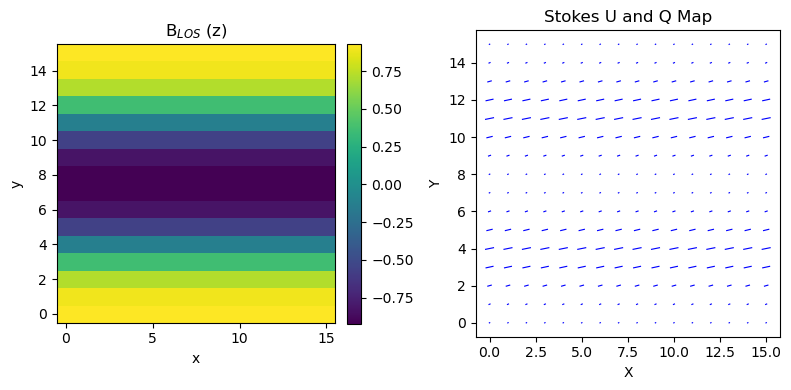

Reconstructing in 3 Dimensions
Ceiling =  16
Restricting... Level =  16
Restricting... Level =  8
Restricting... Level =  4
Restricting... Level =  2
lvl == 1: Bottom reached; Begin Prolongation
[Multigrid]: Complete.


In [6]:
print('===============')
print('Loading data...')
U, Q, COS, B_los_map, Bx, By, Bz = dg.wavy_zeeman_pol_min(box_length=16,amplitude=1.2,frequency=1,x_const=0.2,num_measurements=4,plotting=1)
UQpol_array = [U, Q, COS, B_los_map]

print('Reconstructing in 3 Dimensions')
d3_field = multigrid(UQpol_array)


In [ ]:
bxr, byr, bzr = rf.zeeman_recon(U, Q, COS, B_los_map, plotting=1)

icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g



In [7]:
# resy = np.sqrt(np.mean((bx-bxr)**2 + (by-byr)**2 + (bz-bzr)**2))
residual = np.sqrt(np.mean((iu-u)**2 + (iq-q)**2))
print(residual)


6.904112261803402e-17


# ++++++++++++++++++++++++++++++++++

### Torodial Field Test

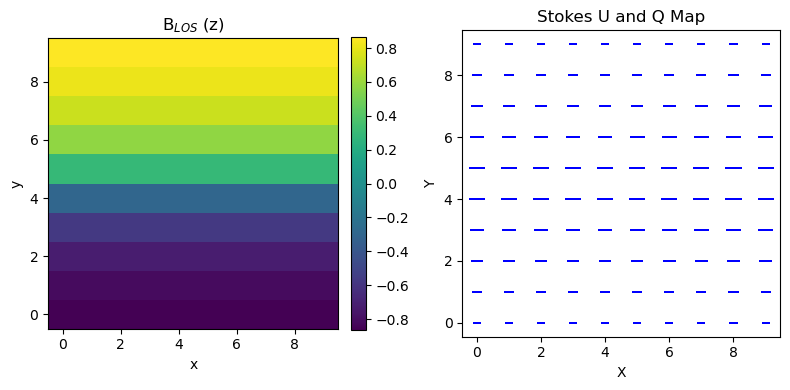

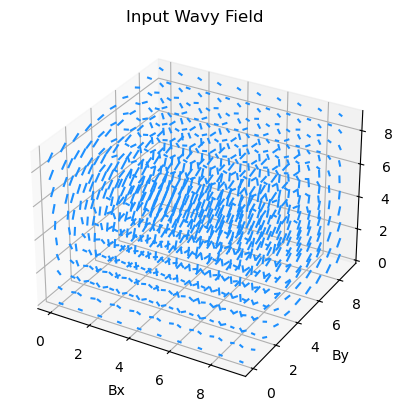

In [11]:
u, q, cos, blos, bx, by, bz = dg.torodial_zeeman_pol(box_length=10,alpha=0,plotting=1)

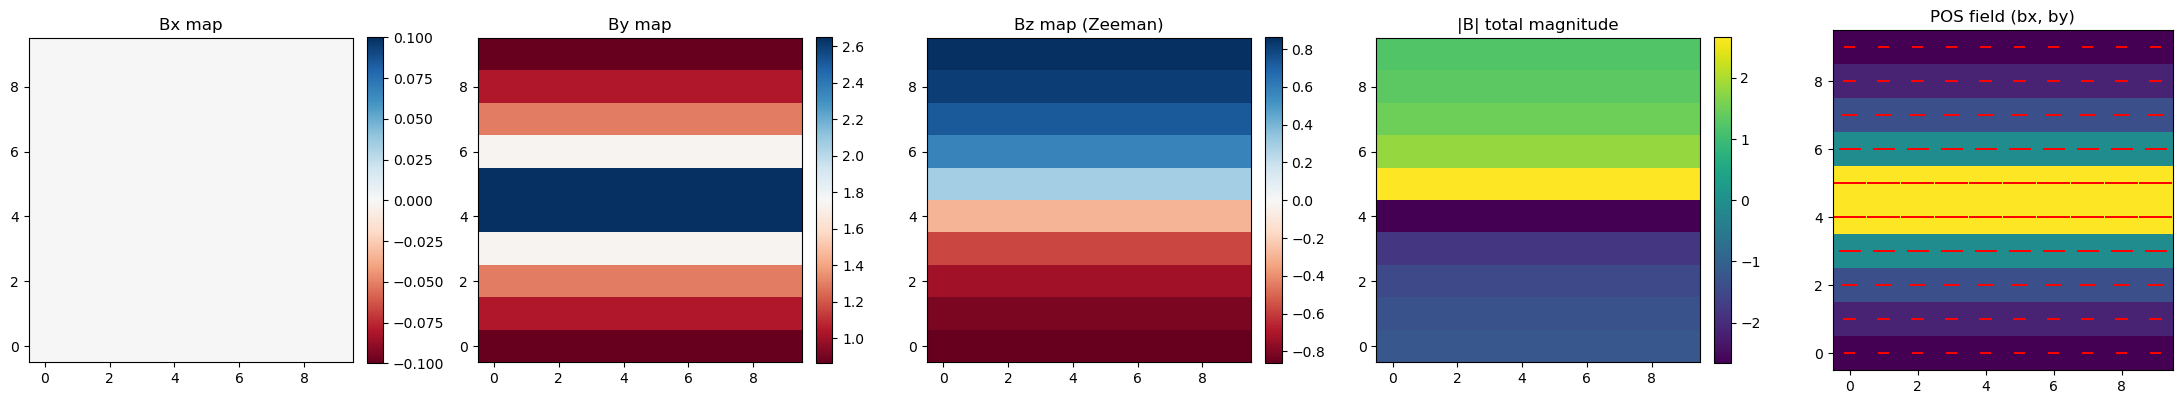

In [ ]:
bxr, byr, bzr = rf.zeeman_recon(u, q, cos, blos, plotting=1)

icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g


In [13]:
residual = np.sqrt(np.mean((iu-u)**2 + (iq-q)**2))
print(residual)

3.510833468576701e-17


In [ ]:
residual_array = []
alpha_array = []

for ia in np.linspace(0.1,10,1000):
    u, q, cos, blos, bx, by, bz = dg.torodial_zeeman_pol(box_length=10,alpha=ia,plotting=0)
    bxr, byr, bzr = rf.zeeman_recon(u, q, cos, blos, plotting=0)

    icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
    iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
    iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g

    residual = np.sqrt(np.mean((iu-u)**2 + (iq-q)**2))
    residual_array.append(residual)
    alpha_array.append(ia)



Text(0.5, 1.0, 'LOS 2.5D Recon Test Torodial Field')

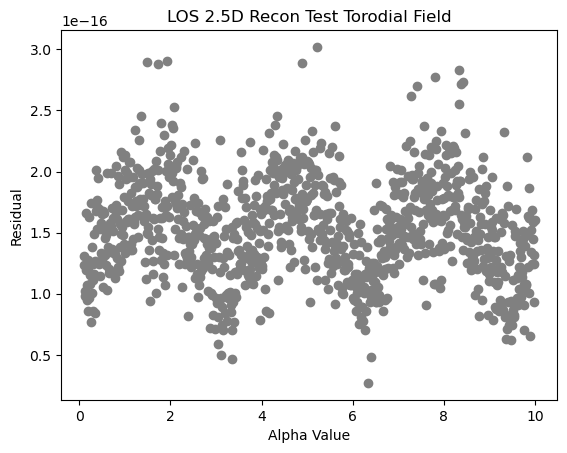

In [16]:
plt.plot(alpha_array, residual_array, marker='o', linestyle='none', color = 'gray')
plt.ylabel('Residual')
plt.xlabel('Alpha Value')
plt.title('LOS 2.5D Recon Test Torodial Field')

Use this program below later, when I need to start making REAL synthetic zeeman maps. 
Maybe implement with Athena++. 
For now, I can just use what I have above. 

In [ ]:
# def synthetic_zeeman_pol_wvy(box_length,amplitude,frequency,y_const,plotting):

#     x = np.linspace(0, 2*np.pi, box_length)
#     y = np.linspace(0, 2*np.pi, box_length)
#     z = np.linspace(0, 2*np.pi, box_length)
#     X, Y, Z = np.meshgrid(x, y, z, indexing="xy")

#     # field geoemtry - wavy
#     angle = amplitude * np.cos(frequency * Y)
#     Bx = np.full_like(X, y_const)      
#     Bz = np.sin(angle)                 
#     By = np.cos(angle)

#     # calculate Stokes U/Q/Cos2g
#     cos2g         = (Bx**2+By**2)/(Bx**2+By**2+Bz**2)
#     q             = (By**2-Bx**2)/(Bx**2+By**2) * cos2g
#     u             = 2*Bx*By/(Bx**2+By**2) * cos2g
#     phi           = 0.5*np.arctan2(u,q)
#     pol           = np.sqrt(u**2+q**2) # which is the same as cos2g in this approach

#     los = np.array([0., 0., 1.])   # unit vector; change as desired
#     los = los / np.linalg.norm(los)

#     # compute B_parallel field: pointwise dot product
#     B_parallel_3d = los[0]*Bx + los[1]*By + los[2]*Bz   # shape (nx,ny,nz)

#     # integrate or average along LOS axis.
#     # If LOS is along z, the axis to collapse is index 2 (the third axis).
#     B_los_map = np.mean(B_parallel_3d, axis=2)   # shape (nx, ny)

#     # Fake spectral line parameters (arbitrary, non-physical)
#     nv = 512
#     v = np.linspace(-5.0, 5.0, nv)   # velocity (or freq) axis in arbitrary units
#     sigma_v = 0.6                    # line width
#     I0 = 1.0                         # peak intensity

#     # weak-Zeeman proportionality constant (choose units so signal is visible)
#     # In real physics this depends on line rest freq and Landé g; here treat as tunable scalar
#     zeta = 0.2   # (velocity unit per unit B) -- tune to get visible splitting

#     # precompute base line (centered at v=0)
#     base_line = I0 * np.exp(-0.5 * (v/sigma_v)**2)

#     nx, ny = box_length, box_length
#     I_cube = np.zeros((nx, ny, nv))
#     V_cube = np.zeros((nx, ny, nv))

#     # loop over sightlines 
#     for i in range(nx):
#         for j in range(ny):
#             Bbar = B_los_map[i, j]                 # LOS field for that pixel
#             delta_v = zeta * Bbar                  # shift of sigma units
#             # Shifted right/left circular polarization profiles:
#             # RCP shifted to +delta, LCP shifted to -delta (or vice versa depending sign convention)
#             I_R = I0 * np.exp(-0.5 * ((v - delta_v)/sigma_v)**2)
#             I_L = I0 * np.exp(-0.5 * ((v + delta_v)/sigma_v)**2)
#             I = 0.5*(I_R + I_L)
#             V = I_R - I_L                          # circular pol. difference (Stokes V)
#             I_cube[i, j] = I
#             V_cube[i, j] = V

#     # Add gaussian observational noise (optional)
#     noise_rms = 5e-3
#     rng = np.random.default_rng(42)
#     V_cube += rng.normal(scale=noise_rms, size=V_cube.shape)
#     I_cube += rng.normal(scale=noise_rms, size=I_cube.shape)

#     # Diagnostics: maps you might want
#     # peak amplitude of V (signed) maximum circular polarization signal at each picel. Observable = 'Zeeman detection strength"
#     V_peak = np.max(V_cube, axis=2)  
#     # integrated absolute V (a simple proxy) Rough measure of total Polarized signal across line
#     V_int = np.trapezoid(np.abs(V_cube), x=v, axis=2)

#     # grab first slice of Stokes U/Q/COS2G
#     U = u[:,:,0]
#     Q = q[:,:,0]
#     COS = cos2g[:,:,0]


#     if plotting == 1:
#         # Plot B_los_map
#         fig, ax = plt.subplots(2,2, figsize=(8,8))
#         im0 = ax[0,0].imshow(B_los_map.T, origin='lower')#, extent=[x.min(), x.max(), y.min(), y.max()])
#         ax[0,0].set_title(r'B$_{LOS}$ (z)')
#         ax[0,0].set_xlabel('x')
#         ax[0,0].set_ylabel('y')
#         plt.colorbar(im0, ax=ax[0,0])
#         # Plot V_peak
#         im1 = ax[1,0].imshow(V_peak.T, origin='lower')#, extent=[x.min(), x.max(), y.min(), y.max()])
#         ax[1,0].set_title('peak Stokes V')
#         ax[1,0].set_xlabel('x')
#         ax[1,0].set_ylabel('y')
#         plt.colorbar(im1, ax=ax[1,0])

#         # plot sample spectrum at center pixel
#         i0, j0 = nx//2, ny//2
#         ax[1,1].plot(v, I_cube[i0, j0], label='I')
#         ax[1,1].plot(v, V_cube[i0, j0], label='V (x10)')
#         ax[1,1].plot(v, 10*V_cube[i0, j0], label='10*V')  # scaled so visible
#         ax[1,1].legend()
#         ax[1,1].set_title(f'Spectra at pixel ({i0},{j0})')

#         # plot stokes U and Q Map
#         X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]), indexing='ij')
#         factor = 1 / np.max(COS)

#         phi = 0.5 * np.arctan2(U, Q)
#         x_scaled = np.sin(phi) * COS * factor
#         y_scaled = np.cos(phi) * COS * factor

#         ax[0,1].set_title('Stokes U and Q Map')
#         ax[0,1].quiver(X,Y,x_scaled,y_scaled, scale=2, scale_units='xy', headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue', alpha=0.7)

#         ax[0,1].set_xlabel('X')
#         ax[0,1].set_ylabel('Y')

#         plt.tight_layout()
#         plt.show()

#     return U, Q, COS, B_los_map.T

# # u, q, cos, blos = zeeman_wvy(box_length=16, amplitude=1.2, frequency=2.0, y_const=0.5)
# # print(u, q, cos, blos)